#### Import all the required packages

In [1]:
## basic packages
import numpy as np
import re
from itertools import product
import csv
import pandas as pd

##gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

##spacy and nltk
import spacy
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS

##vis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#### load the metadata of podcast transcripts

In [2]:
global df, show_descriptions

meta_data = []
with open("../data/metadata.tsv") as csvfile:
    csvreader = csv.reader(csvfile,delimiter="\t")
    for row in csvreader:
        meta_data.append(row)

df = pd.DataFrame(meta_data[1:],columns=meta_data[0])
show_filename_prefixes = df.show_filename_prefix
episode_filename_prefixes = df.episode_filename_prefix
shows = df.groupby(by=['show_name'])
show_names = shows.apply(lambda x: x.show_name.unique()[0])

In [5]:
# show_descriptions_aggregated = shows.apply(lambda x: x.show_description.unique()[0])
# episode_descriptions_aggregated = shows.apply(lambda x: list(x.episode_description))
# descriptions_aggregated = {}
# for k,text in enumerate(episode_descriptions_aggregated):
#     descriptions_aggregated[show_names[k]] = [show_descriptions_aggregated[k]]+text

In [3]:
genres_topics = ["comedy","news","crime","science","economics","politics","education",\
                  "sports","lifestyle","health","wellbeing","religion","faith","music",\
                  "art","fashion","literature","humanities","drama","fitness","drama",\
                  "fantasy","scifi","gameshow","news quiz","games","mental",\
                  "humor","research","technology","society","social","culture","lifestyle",\
                  "songs","cooking","culinary","food","travel","films","film","movies","tv",\
                  "climate","space","planet","digital","artificial intelligence", "ai",\
                  "cars","car","nutrition","wellness","family","history","geography","physics",\
                  "mathematics","math","chemistry","biology","documentary","commentary","nfl",\
                  "mls","nba","mlb","stocks","stock","market","wall","street","business",\
                  "reality","shows","investing","social media","biography","biographies",\
                  "data science","medicine","media","books","book","europe","asia","canada",\
                  "south america","north america","america","usa","netflix","adventure","pets","dogs",\
                  "cats","dog","cat","nintendo","xbox","playstation","ps4","ps5","theatre","mars"\
                  "tennis","australia","conspiracy","war","epidemic","pandemic","climate","change"\
                  "astrology","novel","church","christ","romance","english","kids","astronomy"\
                  "design","entrepreneurship","marketing","digital","crime","mystery","conspiracy",\
                  "mysteries","mysterious","murder","kidnap","thriller","cop","cops","detective","dead",\
                  "homicide","killer","psychopath","serial-killer","true-crime","terror","conspiracy-theory",\
                  "ghost","supernatural","aliens","alien","suspense","fitness","health","diet","nutrition",\
                  "healthy","meditation","mental","physical","excercise","calories","gym","bodybuilding",\
                  "body-building","stamina","strength","excercise","yoga","wellness","market","business",\
                  "invest","stocks","stock","wallstreet","investing","investment","exchange","nyse",\
                  "capital","money","currency","cryptocurrency","blockchain","bitcoin","federal","bank","nft",\
                  "nature","photography","environment","ecosystem","wilderness","animals",\
                  "ocean","climate","landscape","waterfall","glacier","mountains","mountain",\
                  "coastal","geographic","birds","planter","lakes","lake","volcano","earthquake","tsunami",\
                  "flood","draught","zoo","aquarium","desert","forest","forests","everglades",\
                  "cherry-blossom","spring","autumn","summer","winter","earth","planets",\
                  "marshland","frozen-lake","mammals","fish","reptiles","tornado","hurricane",\
                  "storm","thunder-storm","alaska","sahara","ghats","antarctica","arctic","pacific",\
                  "atlantic","garden","plants","himalayas","greenland","north-pole",\
                  "south-pole","greenhouse"]

In [4]:
podcasts_genres_topics = {}
for k,show in enumerate(show_names):
    keywords = show.lower().split(" ")
    for word in keywords:
        if word in genres_topics:
            if (k,show) in podcasts_genres_topics:
                if word not in podcasts_genres_topics[(k,show)]:
                    podcasts_genres_topics[(k,show)].append(word)
            else:
                podcasts_genres_topics[(k,show)] = [word]
podcasts = [item[1] for item in podcasts_genres_topics.keys()]

In [5]:
nlp = spacy.load("en_core_web_sm")
stops_nltk = set(stopwords.words("english"))
stops_spacy = STOP_WORDS.union({'ll', 've', 'pron','okay','oh','like','know','yeah','yea','yep',\
                                "like like","oh like","yeah like","yeah yeah","oh okay","wow","podcast",\
                               "support","anchor","podcasts","episode","http","https","5star","reviews",\
                               "review","instagram","tiktok","amazon","apple","twitter","goole",\
                               "facebook","send","voice message","message","voice","subscribe","follow",\
                               "sponsor","links","easiest","way","fuck","fucking","talk","discuss",\
                               "world","time","want","join","learn","week","things","stuff","find",\
                               "enjoy","welcome","share","talk","talking","people","gmail","help","today",\
                               "listen","best","stories","story","hope","tips","great","journey",\
                               "topics","email","questions","question","going","life","good","friends",\
                               "friend","guys","discussing","live","work","student","students","need",\
                               "hear","think","change","free","better","little","fucking","fuck","shit",\
                                "bitch","sex","easiest","way","currently","follow","follows","needs",\
                               "grow","stay","tuned","walk","understand","tell","tells","ask","helps",\
                                "feel","feels","look","looks","meet","relate","soon","quick","dude","girl",\
                                "girls","guy","literally","spotify","google","totally","played","young",\
                               "begin","began","create","month","year","date","day","terms","lose","list",\
                               "bought","brings","bring","buy","percent","rate","increase","words","value",\
                               "search","awesome","followers","finn","jake","mark","america","american",\
                               "speak","funny","hours","hour","honestly","states","united","franklin",\
                               "patrick","john","build","dave","excited","process","processes","based",\
                                "focus","star","mary","chris","taylor","gotta","liked","hair","adam","chat",\
                               "named","died","born","country","mother","father","children","tools",\
                               "countries","jordan","tommy","listeners","water","jason","lauren","alex",\
                               "laguna","jessica","kristen","examples","example","heidi","stephen","utiful",\
                               "everybody","sorry","came","come","meet","whoa","whoaa","yay","whoaw",\
                               "anybody","somebody","cool","watch","nice","shall"})
stops = stops_nltk.union(stops_spacy)

In [6]:
number_of_topics = [15,20,25,30]
df_parameters = list(product([2,3,4,5,6,7,8,9,10],[0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
hyperparams = list(product(number_of_topics,df_parameters))
cs = []
with open('/home1/sgmark/capstone-project/model/coherence_scores.csv','r') as f:
    reader = csv.reader(f)
    for row in reader:
        cs.append([float(x) for x in row])
        
best_hp_setting = hyperparams[np.argmax([x[5] for x in cs])]

In [22]:
np.argmax([x[4] for x in cs[126:189]])

49

In [23]:
best_hp_setting=(25,df_parameters[49])
print(best_hp_setting)

(25, (9, 0.3))


#### Filtering the shows to be analyzed based on the total number of episodes in the dataset

In [15]:
# ten_to_fifty_episode_podcasts = [item1 for (item1,item2) in descriptions_aggregated.items()\
#                                 if (len(item2) >= 10) and (len(item2) < 50)]
# ten_to_fifty_episodes = [(df[df.show_name == name].show_filename_prefix.iloc[0],\
#                           df[df.show_name == name].episode_filename_prefix)\
#                          for name in ten_to_fifty_episode_podcasts]

#### The individual transcript location

In [ ]:
# def file_location(show,episode):
#     search_string = local_path + "/spotify-podcasts-2020" + "/podcasts-transcripts" \
#                                + "/" + show[0] \
#                                + "/" + show[1] \
#                                + "/" + "show_" + show \
#                                + "/"
#     return search_string

#### load the transcripts

In [11]:
transcripts = {}
for podcast in podcasts:
    for i in shows.get_group(podcast)[['show_filename_prefix','episode_filename_prefix']].index:
        show,episode = shows.get_group(podcast)[['show_filename_prefix','episode_filename_prefix']].loc[i]
        s = show.split("_")[1]
        try:
            with open('/home1/sgmark/podcast_transcripts/'+s[0]+'/'+s[1]+'/'+show+'/'+episode+'.txt','r') as f:
                transcripts[(show,episode)] = f.readlines()
            f.close()
        except Exception as e:
            pass
    
keys = list(transcripts.keys())

In [19]:
# transcripts = {}
# for k,showname in enumerate(show_filename_prefixes):
#     s = showname.split("_")[1]
#     try:
#         with open('../podcast_transcripts/'+s[0]+'/'+s[1]+'/'+showname+'/'+episode_filename_prefixes[k]+'.txt','r') as f:
#             transcripts[(showname,episode_filename_prefixes[k])] = f.readlines()
#         f.close()
#     except Exception as e:
#         pass
    
# keys = list(transcripts.keys())

# transcripts = {}
# for name,list_of_episodes in ten_to_fifty_episodes:
#     s = name.split("_")[1]
#     for episode in list_of_episodes:
#         try:
#             with open('../data/shows_ten_to_fifty_episodes/'+name+'/'+episode+'.txt','r') as f:
#                 transcripts[(name,episode)] = f.readlines()
#             f.close()
#         except Exception as e:
#             pass
    
# keys = list(transcripts.keys())

In [12]:
# Cleaning & remove urls and links
def remove_stops(text,stops):
    final = []
    for word in text:
        if (word not in stops) and (len(word)>3) and (not word.endswith('ing')) and (not word.endswith('ly')):
            final.append(word)
    return final
                       
def clean_text(docs):
    final = []
    for doc in docs:
        clean_doc = remove_stops(doc, stops)
        final.extend(clean_doc)
    return final

def lemmatization(text_data): 
    nlp = spacy.load("en_core_web_sm")
    texts = []
    for text in text_data:
        doc = nlp(text)
        lem_text = []
        for token in doc:
            if (token.pos_=="VERB") or (token.pos_=="ADV"):
                pass
            else:
                lem_text.append(token.lemma_)
        texts.append(lem_text)
    return texts

#### tokenize/convert text into words

In [13]:
def normalize_docs(text_data):
    final_texts = []
    for text in text_data:
        new_text = gensim.utils.simple_preprocess(text,deacc=True)
        final_texts.append(new_text)
    return final_texts

In [14]:
docs = []
for text in transcripts.values():
    docs.append(' '.join(clean_text(normalize_docs(text))))
    
texts = lemmatization(docs)
texts = [remove_stops(text,stops) for text in texts]

### Using bigrams

In [15]:
from gensim.models.phrases import Phrases

bigram = Phrases(texts, min_count=5)

for i in range(len(texts)):
    for token in bigram[texts[i]]:
        if '_' in token:
            texts[i].append(token)

In [24]:
# import pickle
# pickle.dump(texts,open('all_genres_texts.pkl','wb'))

#### Construct a corpus of words as a bag of words 

In [24]:
dictionary = corpora.Dictionary(texts)

dictionary.filter_extremes(no_below=best_hp_setting[1][0],no_above=best_hp_setting[1][1])

In [25]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [14]:
# from itertools import product

# number_of_topics = [15,20,25,30]
# df_parameters = list(product([2,3,4,5,6,7,8,9,10],[0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
# coherence_scores_umass = np.zeros((len(number_of_topics),len(df_parameters)))
# coherence_scores_uci = np.zeros((len(number_of_topics),len(df_parameters)))
# coherence_scores_npmi = np.zeros((len(number_of_topics),len(df_parameters)))

# j = 0
# for num in number_of_topics:
#     i = 0
#     for n,m in df_parameters:
#         dictionary = corpora.Dictionary(texts)
#         dictionary.filter_extremes(no_below=n,no_above=m)
#         corpus = [dictionary.doc2bow(text) for text in texts]
#         num_topics = num
#         chunksize = 5000
#         passes = 20
#         iterations = 500
#         eval_every = None

#         lda_model = gensim.models.ldamodel.LdaModel(corpus,
#                                                    id2word=dictionary,
#                                                    num_topics=num_topics,
#                                                    chunksize=chunksize,
#                                                    passes=passes,
#                                                    iterations=iterations,
#                                                    alpha='auto',
#                                                    eta='auto',
#                                                    random_state = 123,
#                                                    eval_every=eval_every)
#         cm = CoherenceModel(lda_model, texts=texts,corpus=corpus, coherence= 'c_uci')
#         coherence_scores_uci[j,i] = cm.get_coherence()
#         cm = CoherenceModel(lda_model, texts=texts,corpus=corpus, coherence= 'c_npmi')
#         coherence_scores_npmi[j,i] = cm.get_coherence() 
#         cm = CoherenceModel(lda_model, corpus=corpus, coherence= 'u_mass')
#         coherence_scores_umass[j,i] = cm.get_coherence()
#         with open("coherence_scores-Copy-1.csv",'a') as f:
#             writer = csv.writer(f)
#             writer.writerow([num,n,m,coherence_scores_uci[j,i],coherence_scores_npmi[j,i],\
#                              coherence_scores_umass[j,i]])
#         i += 1
#         print(i)
#     j += 1
#     print(j)

In [26]:
best_hp_setting

(25, (9, 0.3))

In [27]:
%%time
import logging
logging.basicConfig(filename='example.log', encoding='utf-8',format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)
# logging.basicConfig(filename='example.log', filemode = 'w+', encoding='utf-8', level=logging.DEBUG)
# logging.debug('This message should go to the log file')
# logging.info('So should this')
# logging.warning('And this, too')
# logging.error('And non-ASCII stuff, too, like Øresund and Malmö')

num_topics = best_hp_setting[0]
chunksize = 10000
passes = 50
iterations = 1000
eval_every = None

lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           chunksize=chunksize,
                                           passes=passes,
                                           iterations=iterations,
                                           alpha='auto',
                                           eta='auto',
                                           random_state=123,
                                           eval_every=eval_every)

CPU times: user 1h 33min 36s, sys: 3h 36min 25s, total: 5h 10min 2s
Wall time: 26min 52s


In [37]:
top_topics = lda_model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics])/num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -1.3739.


In [38]:
cm = CoherenceModel(lda_model, texts = texts, corpus=corpus, coherence='c_npmi')
coherence = cm.get_coherence() 
print(coherence)
for x in cm.get_coherence_per_topic(): print(x)

0.0707143230785898
0.1170584497083885
0.09140337212773494
0.04323670582529995
0.12465801346819048
0.04722375459756316
0.08521718200611593
0.15673426907575727
0.027163203216283616
0.044595896550435235
0.0964516368412
0.04746737900116549
-0.00011717290842249209
-0.026631892407582982
0.10368424056356053
0.05727878306272983
0.05502600470497585
0.06633732125214177
0.05796829063512643
0.020923137812854556
0.10346097846643743
0.15124804366150882
0.03298144015094524
0.02953710577174835
0.07376320514834851
0.08368846296109794
0.21974947516500962
0.044880807022618464
8.448181591426422e-05
0.0881105619225961
0.07824655513795109


### Visualizing data

In [28]:
vis = pyLDAvis.gensim_models.prepare(lda_model,corpus,dictionary,mds="mmds",R=20)
pyLDAvis.save_json(vis,'all_genres_25_npmi.json')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7      0.108222 -0.000207       1        1  9.660032
5     -0.155547 -0.007447       2        1  7.433726
2     -0.156308 -0.122535       3        1  6.717014
17     0.242095  0.269629       4        1  5.565905
16     0.015527  0.050477       5        1  5.362254
12     0.005096  0.175128       6        1  5.185990
20    -0.021270 -0.037110       7        1  5.094884
8      0.267185 -0.176879       8        1  4.784107
1      0.157419  0.070554       9        1  4.754485
15     0.336435 -0.054965      10        1  4.561997
9      0.138505 -0.238721      11        1  4.075569
4      0.233466 -0.078792      12        1  3.835853
21    -0.288679 -0.090952      13        1  3.725533
10    -0.134609  0.129841      14        1  3.356814
13    -0.019624 -0.256147      15        1  3.190653
3     -0.053184 -0.160480      16        1  3.075485
24    -0.245903 -0.235972      17        1  3.059201
0      0.131235  0.265748      18        1  2.782193
22    -0.396742  0.205512      19        1  2.628862
11    -0.154485 -0.317713      20        1  2.149027
6      0.109279 -0.394681      21        1  1.955923
19    -0.087449  0.291524      22        1  1.944047
14     0.298851  0.180451      23        1  1.922072
18    -0.295378  0.067928      24        1  1.798166
23    -0.034133  0.465811      25        1  1.380206, topic_info=         Term          Freq         Total Category  logprob  loglift
59      movie  20053.000000  20053.000000  Default  20.0000  20.0000
595    player  12534.000000  12534.000000  Default  19.0000  19.0000
636    season  16778.000000  16778.000000  Default  18.0000  18.0000
8279  bitcoin   7169.000000   7169.000000  Default  17.0000  17.0000
2228   murder   9983.000000   9983.000000  Default  16.0000  16.0000
...       ...           ...           ...      ...      ...      ...
2425     neck    601.290562   1780.141391  Topic25  -4.9807   3.1976
1251  release    593.330576   3484.219872  Topic25  -4.9940   2.5127
112     chest    519.914533   1341.268765  Topic25  -5.1261   3.3352
473    ground    583.441244   3960.087268  Topic25  -5.0108   2.3679
381     block    568.960610   3283.270086  Topic25  -5.0359   2.5302

[1401 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
19206      4  0.993591  aaron_jones
2306       1  0.039463      account
2306       2  0.375685      account
2306       3  0.036331      account
2306       4  0.012528      account
...      ...       ...          ...
1414      24  0.000186      youtube
1414      25  0.000558      youtube
23247      6  0.983001        zelda
23247      9  0.013954        zelda
23247     12  0.001550        zelda

[11247 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 3, 18, 17, 13, 21, 9, 2, 16, 10, 5, 22, 11, 14, 4, 25, 1, 23, 12, 7, 20, 15, 19, 24])

In [141]:
# from pprint import pprint
# pprint(top_topics)

In [41]:
import pickle

pickle.dump(lda_model,open('../model/all_genres_lda_model_30_npmi.pkl','wb'))
pickle.dump(dictionary,open('../model/all_genres_dictionary_30_npmi.pkl','wb'))
pickle.dump(corpus,open('../model/all_genres_corpus_30_npmi.pkl','wb'))

In [32]:
# import pickle

# file = open('../model/most_recent_lda_model.pkl','rb')
# lda_model = pickle.load(file)
# file.close()

# file = open('../model/genre_assigned_shows_corpus.pkl','rb')
# corpus = pickle.load(file)
# file.close()

# file = open('../model/genre_assigned_shows_dictionary.pkl','rb')
# dictionary = pickle.load(file)
# file.close()

In [42]:
def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    podcast_list = []
    episode_list = []
    duration_list = []
    publisher_list = []
    show_prefix_list = []
    episode_prefix_list = []
    descriptions_list = []
    rss_link_list = []
    
    for key,wc in zip(keys,bow):
        show_prefix_list.append(key[0])
        episode_prefix_list.append(key[1])
        podcast_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].show_name.iloc[0])
        episode_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].episode_name.iloc[0])
        duration_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].duration.iloc[0])
        publisher_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].publisher.iloc[0])
        descriptions_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].episode_description.iloc[0])
        rss_link_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].rss_link.iloc[0])
        
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(show_prefix_list, name='show_filename_prefix'),
                           pd.Series(episode_prefix_list, name='episode_filename_prefix'),
                           pd.Series(podcast_list, name='Podcast_name'),
                           pd.Series(episode_list, name='Episode_name'),
                           pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords'),
                           pd.Series(duration_list, name='Duration of the episode'),
                           pd.Series(publisher_list, name='Publisher of the show'),
                           pd.Series(descriptions_list, name='Description of the episode'),
                           pd.Series(rss_link_list, name='rss_link')], axis=1)

    return result_df

In [43]:
import pandas as pd

main_topic_df = get_main_topic_df(lda_model,corpus,texts)
main_topic_df.to_pickle('../model/all_genres_main_df_30_npmi.pkl')

In [44]:
main_topic_df.to_csv('../model/all_genres_main_df_30_npmi.csv')
main_topic_df.head(5)

,show_filename_prefix,episode_filename_prefix,Podcast_name,Episode_name,Dominant_topic,Percent,Processed_text,Keywords,Duration of the episode,Publisher of the show,Description of the episode,rss_link
0,show_0RsrVs9sRhRhpvtmWr4gOV,1iTa8ULZbLTWnU48oojIjn,Best Fitness Blogs,10 Best Fitness Blogs in 2020,0,0.616,"[fitness, blog, lifestyle, disease, mission, h...",body calorie diet fitness food goal health hea...,1.6940333333333333,mary glory,lifestyle diseases! They rank best in the miss...,https://anchor.fm/s/129ad6b8/podcast/rss
1,show_1U5N8n4XDifDgratYU5A0p,3Of6aAHLCAOwvgTLC2HI6h,DRAMA BLOGS,TOP 10 KOREAN DRAMA BLOGS ON THE INTERNET TODA...,2,0.539,"[korean, drama, blog, internet, korean, drama,...",book dead film ghost horror house moment moon ...,2.077166666666667,nnedimma okoro,"Aside from K-pop, another component of the Kor...",https://anchor.fm/s/127cb250/podcast/rss
2,show_50UBdcuhwW2HitNElGLdC6,2EYwa799Unm8IhtDfZSA75,The Mindful Cops,My Journey and What's to Come,29,0.397,"[mindful, kind, experience, career, mindfulnes...",body case crime death evidence killer murder p...,28.452966666666665,Joe Cefalu,This episode is about my journey into mindfuln...,https://anchor.fm/s/12493060/podcast/rss
3,show_6S7xPTkVVxfkRcVlgyNSA9,0NVURrFQ7Se20NuZ2uM7Xz,"""Mind"" Your Business With Satyam Tiwari | Pers...",How to grow your following on any social media...,28,0.948,"[discussion, social, medium, platform, wise, a...",account brand business content medium page pos...,0.9798833333333332,Satyam Tiwari,This episode tells you how you could grow your...,https://anchor.fm/s/f528e9c/podcast/rss
4,show_6S7xPTkVVxfkRcVlgyNSA9,5aohOxM9Fd9DLRAaHWrhMK,"""Mind"" Your Business With Satyam Tiwari | Pers...",Art Of Branding.,28,0.467,"[brand, brand, company, personality, overall, ...",account brand business content medium page pos...,1.3684333333333334,Satyam Tiwari,This episode tells you about the art of Brandi...,https://anchor.fm/s/f528e9c/podcast/rss


In [26]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("darkgrid")
# plt.figure(figsize=(10,8))
# grouped_topics = main_topic_df.groupby('Dominant_topic')
# grouped_topics.count()['Processed_text'].\
#     plot.bar(rot=0).\
#     set(title='Dominant Topic Frequency in the {} podcast episodes'.format(len(texts)),
#         ylabel='Topic frequency'); 

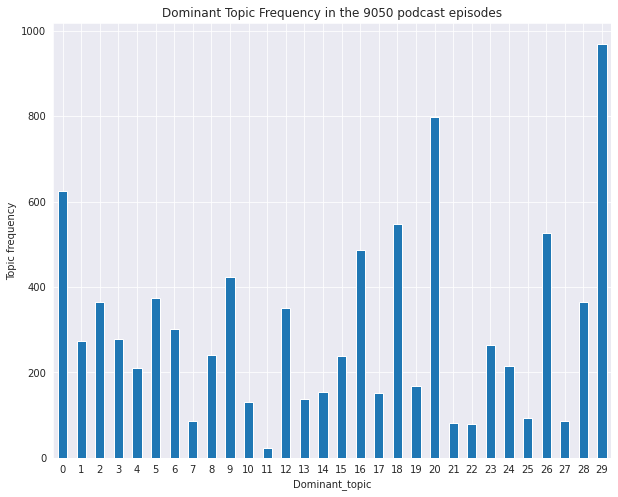

In [45]:
plt.figure(figsize=(10,8))
grouped_topics = main_topic_df.groupby('Dominant_topic')
grouped_topics.count()['Podcast_name'].\
    plot.bar(rot=0).\
    set(title='Dominant Topic Frequency in the {} podcast episodes'.format(len(texts)),
        ylabel='Topic frequency'); 

In [46]:
representatives = pd.DataFrame()

for k in grouped_topics.groups.keys():
    representatives = pd.concat([representatives, 
                                 grouped_topics.get_group(k).sort_values(['Percent'], ascending=False).head(3)])
    
representatives.to_csv('../model/main_df_csv/all_genres_representatives_30_npmi.csv')
    
# for k,words in enumerate(representatives.Keywords):
#     print(f'topic {k}: {words}')

In [33]:
# print('Document: {}  Dominant topic: {}\n'.format(representatives.index[0], 
#                                        representatives.loc[representatives.index[0]]['Dominant_topic']))
# print([sentence.strip() for sentence in transcripts[keys[representatives.index[0]]]])

In [60]:
num_topics = 30
def word_count_by_topic(topic=0):
    d_lens = [len(d) for d in grouped_topics.get_group(topic)['Processed_text']]
    plt.figure(figsize=(10,8))
    plt.hist(d_lens)
    large = plt.gca().get_ylim()[1]
    d_mean = round(np.mean(d_lens), 1)
    d_median = np.median(d_lens)
    plt.plot([d_mean, d_mean], [0,large], label='Mean = {}'.format(d_mean))
    plt.plot([d_median, d_median], [0,large], label='Median = {}'.format(d_median))
    plt.legend()
    plt.xlabel('Document word count',fontsize=16)
    plt.ylabel('Number of documents',fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

In [61]:
from ipywidgets import interact, IntSlider

slider = IntSlider(min=0, max=num_topics-1, step=1, value=0, description='Topic')
interact(word_count_by_topic, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=29), Output()), _dom_classes=('widget-intera…

In [62]:
lda_top_words_index = set()
for i in range(lda_model.num_topics):
    lda_top_words_index = lda_top_words_index.union([k for (k,v) in lda_model.get_topic_terms(i)[:5]])

print('Indices of top words: \n{}\n'.format(lda_top_words_index))

Indices of top words: 
{1, 2819, 1283, 771, 519, 6668, 781, 13, 3853, 17, 275, 2069, 22, 3095, 3351, 1814, 2073, 1820, 798, 1058, 1585, 1331, 2356, 3379, 51, 2099, 1080, 572, 64, 1602, 66, 1090, 323, 5444, 1863, 581, 1098, 1872, 5201, 594, 1110, 4184, 88, 91, 1373, 350, 1630, 8289, 8036, 614, 872, 617, 2920, 2923, 2157, 11374, 111, 114, 116, 3704, 5497, 1148, 125, 1662, 638, 8575, 1151, 10369, 2429, 1156, 640, 2951, 9353, 7819, 397, 9614, 2446, 916, 661, 150, 2202, 3227, 3228, 2719, 3490, 3235, 2211, 1445, 3492, 169, 6570, 5035, 430, 9399, 6583, 10427, 700, 4798, 2752, 706, 4035, 8644, 8389, 10182, 199, 709, 450, 9675, 9421, 14542, 2512, 723, 1236, 467, 728, 2271, 9699, 6885, 21989, 230, 2280, 2025, 1260, 4846, 497, 760, 249, 3322, 1275, 1021}



In [63]:
words_we_care_about = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in list(lda_top_words_index)} 
                       for lst in corpus]

In [64]:
lda_top_words_df = pd.DataFrame(words_we_care_about).fillna(0).astype(int).sort_index(axis=1)
lda_top_words_df['Cluster'] = main_topic_df['Dominant_topic']

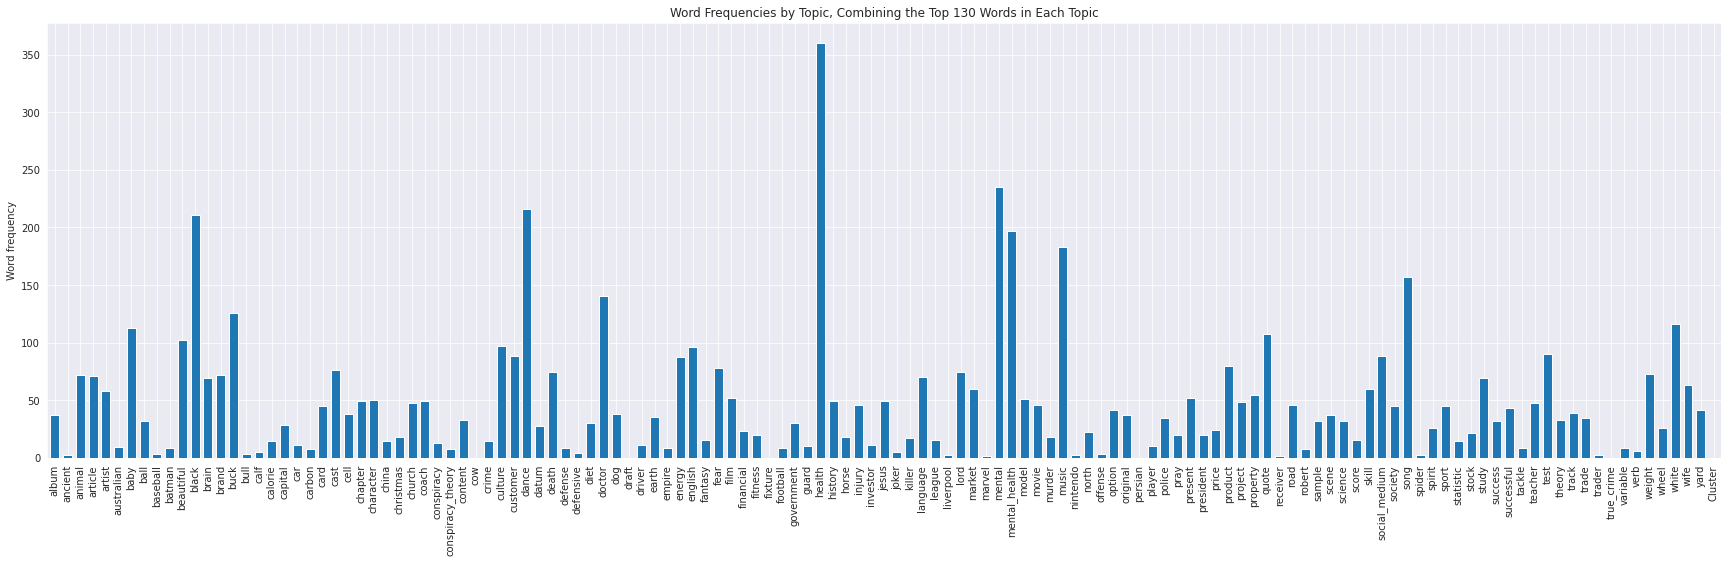

In [65]:
clusterwise_words_dist = lda_top_words_df.groupby('Cluster').get_group(0)

clusterwise_words_dist.sum().transpose().\
         plot.bar(figsize=(30, 8), width=0.7).\
         set(ylabel='Word frequency', 
         title='Word Frequencies by Topic, Combining the Top {} Words in Each Topic'.format(len(lda_top_words_index)));